This notebook is adapted from the original by Kevin Murphy, here: https://github.com/probml/pyprobml/blob/master/notebooks/book1/07/linalg.ipynb. 
The original is written using JAX, which is replaced with numpy for this notebook.

## Machine Learning for Neuroscience, <br>Department of Brain Sciences, Faculty of Medicine, <br> Imperial College London
### Contributors: Alex Capstick, Francesca Palermo, Nan Fletcher-Lloyd, Yu Chen, Tianyu Cui, Marirena Bafaloukou, Ruxandra Mihai, Payam Barnaghi
**Spring 2024**

# Linear algebra

## TOC:
* [Basics](#basics)
* [Sparse matrices](#sparse)
* [Broadcasting](#broadcasting)
* [Einstein summation](#einstein)
* [Eigenvalue decomposition](#EVD)
* [Singular value decomposition](#SVD)
* [Other decompositions](#decomp)

In [1]:
# Standard Python libraries
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np

np.set_printoptions(precision=3)
import matplotlib.pyplot as plt

import seaborn as sns

sns.set(style="ticks", color_codes=True)

## Basics <a class="anchor" id="basics"></a>

In [2]:
# Create 1d vector
v = np.array([0, 1, 2])  # 1d vector
print(v.ndim)  ## 1
print(v.shape)  ## (3,)

1
(3,)


In [3]:
# Note that Python uses 0-indexing, not 1-indexing.
# Thus the elements are accessed as follows:
print(v[0], v[1], v[2])  ## 0 1 2

0 1 2


In [4]:
# Create 2d array
A = np.array([[0, 1, 2], [3, 4, 5]])
print(A)
## [[0, 1, 2],
##  [3, 4, 5]])
print(A.ndim)  ## 2
print(A.shape)  ## (2,3)
print(A.size)  ## 6
print(A.T.shape)  ## (3,2)

[[0 1 2]
 [3 4 5]]
2
(2, 3)
6
(3, 2)


In [5]:
# If we want to make a vector into a matrix with one row, we can use any of the following:

x = np.array([1, 2])  # vector
X1 = np.array([x])  # matrix with one row
X2 = np.reshape(x, (1, -1))
X3 = x[None, :]
X4 = x[np.newaxis, :]
assert np.array_equal(X1, X2)
assert np.array_equal(X1, X3)
print(np.shape(X1))  ## (1,2)

(1, 2)


In [6]:
# If we want to make a vector into a matrix with one column, we can use any of the following:
x = np.array([1, 2])  # vector
X1 = np.array([x]).T  # matrix with one column
X2 = np.reshape(x, (-1, 1))
X3 = x[:, None]
X4 = x[:, np.newaxis]
assert np.array_equal(X1, X2)
assert np.array_equal(X1, X3)
print(np.shape(X1))  ## (2,1)

(2, 1)


In [7]:
# Here is how to create a one-hot encoding of integers.


def one_hot(x, k, dtype=np.float32):
    return np.array(x[:, None] == np.arange(k), dtype)


# Example
x = np.array([1, 2, 0, 2])
X = one_hot(x, 3)
print(X)

[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [8]:
# We can construct arrays from a list of column vectors as follows:
A1 = np.array([[0, 1, 2], [3, 4, 5]])
col0 = A1[:, 0]
col1 = A1[:, 1]
col2 = A1[:, 2]
A2 = np.stack([col0, col1, col2], axis=1)
assert np.array_equal(A1, A2)

# We can construct arrays from a list of row vectors as follows:
row0 = A1[0, :]
row1 = A1[1, :]
A2 = np.stack([row0, row1], axis=0)
assert np.array_equal(A1, A2)

In [9]:
# We can construct arrays from a list of arrays
# using the hstack or vstack functions,
# which stack horizontally or vertically,  as illustrated below.

M = np.array([[9, 8, 7], [6, 5, 4]])
C = np.array([[99], [99]])
A1 = np.concatenate([M, C], axis=1)
A2 = np.hstack([M, C])
# A3 = np.c_[M, C] 
assert np.array_equal(A1, A2)
# assert np.array_equal(A1, A3)
print(A1)

[[ 9  8  7 99]
 [ 6  5  4 99]]


In [10]:
R = np.array([[1, 2, 3]])
A1 = np.concatenate([R, M], axis=0)
A2 = np.vstack([R, M])
assert np.array_equal(A1, A2)
print(A1)

[[1 2 3]
 [9 8 7]
 [6 5 4]]


In [11]:
# A very common idiom  is to add a column of 1s to a datamatrix.
# We can do this using horizontal stacking (along the columns) as follows.

X = np.array([[9, 8, 7], [6, 5, 4]])
N = np.shape(X)[0]  # num. rows
X1 = np.hstack([np.ones((N, 1)), X])
print(X1)

[[1. 9. 8. 7.]
 [1. 6. 5. 4.]]


In [12]:
# We can flatten a matrix to a vector (concatenating its rows, one by one) using ravel

A = np.reshape(np.arange(6), (2, 3))
print(A.ravel())  ##  [0 1 2 3 4 5]

[0 1 2 3 4 5]


In numpy,  arrays are layed out in memory
such that, if we iterate over neighboring elements,
the rightmost index changes the fastest.
This is called row-major order,
and is used by other languages such as C++, Eigen and PyTorch.
By contrast, other languages (such as Julia, Matlab, R and Fortran)
use column-major order.
See below for an illustration of the difference.


<img src="https://upload.wikimedia.org/wikipedia/commons/4/4d/Row_and_column_major_order.svg" width="200">


(Source: https://commons.wikimedia.org/wiki/File:Row_and_column_major_order.svg)

Thus in numpy, for speed reasons, we should always write loops like this:
```
A = np.reshape(np.arange(6),(2,3))
d1, d2 = np.shape(A)
for i in range(d1):
  for j in range(d2):
    # Do something with A[i,j]
 ```

For similar reasons, data matrices are usually stored
in the form $(N,D)$, where $N$ is the batchsize (number of examples),
so that we can efficiently extract minibatches by slicing blocks of consecutive memory.

In [13]:
## We can create a tensor in numpy as in this example:

# T = np.ndarray([2,3,4]) # fill with random values
T = np.zeros((2, 3, 4))
T = np.reshape(np.arange(24), (2, 3, 4))  # fill with 0..23
print(np.shape(T))
print(T)

(2, 3, 4)
[[[ 0  1  2  3]
  [ 4  5  6  7]
  [ 8  9 10 11]]

 [[12 13 14 15]
  [16 17 18 19]
  [20 21 22 23]]]


In [14]:
# We can permute the order of the dimensions using np.transpose.

x = np.ones((1, 2, 3))
print(np.transpose(x, (1, 0, 2)).shape)  ## (2, 1, 3)

# Note that this does not actually move the data in memory
# (which would be slow),
# it merely provides a different \keywordDef{view} of the same data,
# i.e., it changes the mapping from $n$-dimensional vectors of
# subscripts to 1d integers.

(2, 1, 3)


In [15]:
# matrix multiplication

A = np.random.rand(2, 3)
B = np.random.rand(3, 4)
C = np.dot(A, B)
assert np.shape(C) == (2, 4)
print(C)
C2 = A.dot(B)
C3 = A @ B
assert np.allclose(C, C2)
assert np.allclose(C, C3)

# Note that we need to use np.dot(A,B)
# if we use A * B, Python tries to compute the elementwise product,
# which is invalid, since $A$ and $B$ have incompatible shapes.

[[1.521 1.209 0.814 1.245]
 [0.757 0.704 0.802 0.481]]


In [16]:
# Outer products

x = np.arange(1, 3)
y = np.arange(1, 3)
A = np.outer(x, y)
print(A)

[[1 2]
 [2 4]]


In [17]:
# We can sum across the rows

X = np.reshape(np.arange(6), (2, 3))
XS = np.dot(np.ones((1, 2)), X)
print(XS)
XS2 = np.sum(X, axis=0)
assert np.allclose(XS, XS2)

[[3. 5. 7.]]


In [18]:
# We can sum across the columns

X = np.reshape(np.arange(6), (2, 3))
XS = np.dot(X, np.ones((3, 1)))
print(XS)
XS2 = np.sum(X, axis=1).reshape(-1, 1)
assert np.allclose(XS, XS2)

[[ 3.]
 [12.]]


In [19]:
# We can sum across all entries

X = np.reshape(np.arange(6), (2, 3))
S1 = np.dot(np.ones((1, 2)), np.dot(X, np.ones((3, 1))))[0]
S2 = np.sum(X)
assert np.allclose(S1, S2)

In [20]:
# Kronecker product

np.kron(np.eye(2), np.ones((2, 2)))

array([[1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [0., 0., 1., 1.],
       [0., 0., 1., 1.]])

In [21]:
# Vector Norms
x = np.arange(6)
print(np.linalg.norm(x, 2) ** 2)
print(np.sum(np.power(x, 2)))
print(np.linalg.norm(x, np.inf))

# Matrix norms
A = np.random.randn(4, 4)
print(np.linalg.norm(A, ord=2))
print(np.linalg.norm(A, ord="nuc"))
print(np.linalg.norm(A, ord="fro"))

55.0
55
5.0
3.9332674444435227
7.018016250025435
4.504057956917984


In [22]:
# Size of a matrix

print(np.trace(A))
print(np.linalg.det(A))
print(np.linalg.cond(A))

0.8310587056548608
-1.9790321790547125
10.302782656866258


## Sparse matrices  <a class="anchor" id="sparse"></a>

In [23]:
from scipy.sparse import diags

A = diags([1, 2, 3])
print(A)
print(A.toarray())

  (0, 0)	1.0
  (1, 1)	2.0
  (2, 2)	3.0
[[1. 0. 0.]
 [0. 2. 0.]
 [0. 0. 3.]]


In [24]:
# Block diagonal

from scipy.linalg import block_diag

block_diag([2, 3], [[4, 5], [6, 7]])

array([[2, 3, 0, 0],
       [0, 0, 4, 5],
       [0, 0, 6, 7]])

Band diagonal

See (https://pypi.org/project/bandmat)

## Broadcasting  <a class="anchor" id="broadcasting"></a>

In numpy, the command A * B computes the elementwise multiplication of arrays or tensors A and B.
If these arrays have different shapes,
they will be automatically converted to have compatible shapes by
implictly replicating  certain dimensions; this is called
**broadcasting**. The following conversion rules are applied
in order:

* If the two arrays differ in their number of dimensions, the
   shape of the one with fewer dimensions is padded with ones on the
   left side. For example, a scalar will be converted to a vector,
   and a vector to a matrix with one row.
* If the shape of the two arrays does not match in any dimension,
   the array with shape equal to 1 in that dimension is stretched to
   match the other shape, by replicating the corresponding contents.
* If in any dimension the sizes disagree and neither is equal to
   1, an error is raised.



<img src="https://github.com/probml/pyprobml/blob/master/book1/linalg/figures/broadcasting.png?raw=True" width="400">



Figure made by [broadcasting_fig.py](https://github.com/probml/pyprobml/blob/master/scripts/broadcasting_fig.py) by Jake VanderPlas.


In [25]:
# Example: scaling each column
X = np.reshape(np.arange(6), (2, 3))
s = np.array([1, 2, 3])
XS = X * s
print(XS)
XS2 = np.dot(X, np.diag(s))  # post-multiply by diagonal
assert np.allclose(XS, XS2)

[[ 0  2  6]
 [ 3  8 15]]


In [26]:
# Example: scaling each row
X = np.reshape(np.arange(6), (2, 3))
s = np.array([1, 2])
XS = X * np.reshape(s, (-1, 1))
print(XS)
XS2 = np.dot(np.diag(s), X)  # pre-multiply by diagonal
assert np.allclose(XS, XS2)

[[ 0  1  2]
 [ 6  8 10]]


## Einstein summation  <a class="anchor" id="broadcasting"></a>

Einstein summation lets us write formula such as  inputs -> outputs, which name the dimensions 
of the input tensor and output tensors; dimensions which are not named in the output are summed over - this is called **tensor contraction**.


In [27]:
# Sample data
a = np.arange(3)
b = np.arange(3)
A = np.arange(6).reshape(2, 3)
B = np.arange(15).reshape(3, 5)
S = np.arange(9).reshape(3, 3)
T = np.random.randn(2, 2, 2, 2)

Now consider einsum with  a single tensor.

In [28]:
# Matrix transpose
assert np.allclose(A.T, np.einsum("ij->ji", A))

# Sum all elements
assert np.allclose(np.sum(A), np.einsum("ij->", A))

# Sum across rows
assert np.allclose(np.sum(A, axis=0), np.einsum("ij->j", A))

# Sum across columns
assert np.allclose(np.sum(A, axis=1), np.einsum("ij->i", A))

# Sum specific axis of tensor
assert np.allclose(np.sum(T, axis=1), np.einsum("ijkl->ikl", T))
assert np.allclose(np.sum(np.sum(T, axis=0), axis=0), np.einsum("ijkl->kl", T))

# repeated indices with one arg extracts diagonals
assert np.allclose(np.diag(S), np.einsum("ii->i", S))

# Trace
assert np.allclose(np.trace(S), np.einsum("ii->", S))

Now consider einsum with 2 tensors.

In [29]:
# Matrix vector multiplication
assert np.allclose(np.dot(A, b), np.einsum("ik,k->i", A, b))

# Matrix matrix multiplication
assert np.allclose(np.dot(A, B), np.einsum("ik,kj->ij", A, B))
assert np.allclose(np.matmul(A, B), np.einsum("ik,kj->ij", A, B))

# Inner product
assert np.allclose(np.dot(a, b), np.einsum("i,i->", a, b))
assert np.allclose(np.inner(a, b), np.einsum("i,i->", a, b))

# Outer product
assert np.allclose(np.outer(a, b), np.einsum("i,j->ij", a, b))

# Elementwise product
assert np.allclose(a * a, np.einsum("i,i->i", a, a))
assert np.allclose(A * A, np.einsum("ij,ij->ij", A, A))
assert np.allclose(np.multiply(A, A), np.einsum("ij,ij->ij", A, A))

 As a more complex example,
 suppose we have a 3d tensor $S_{ntk}$ where $n$ indexes examples in the
 batch, $t$ indexes locations in the sequence, and $k$ indexes words
 in a one-hot representation.
 Let $W_{kd}$ be an embedding matrix that maps sparse one-hot vectors
 $R^k$  to dense vectors in $R^d$.
 We can convert the batch of sequences of one-hots
 to a batch of sequences of embeddings as follows:
$$
E_{ntd} = \sum_k S_{ntk} W_{kd}
$$
We can compute the sum of the embedding vectors for
each sequence (to get a global representation
of each bag of words) as follows:
$$
E_{nd} = \sum_k \sum_t S_{ntk} W_{kd}
$$
Finally we can pass each sequence's vector representation
through another linear transform $V_{dc}$ to map to the logits over a
classifier
with $c$ labels:
$$
L_{nc} = \sum_d E_{nd} V_{dc}
= \sum_d \sum_k \sum_t S_{ntk} W_{kd} V_{dc}
$$
In einsum notation, we have
$$
L_{nc} = S_{ntk} W_{kd} V_{dc}
$$
We sum  over $k$ and $d$  because those
indices occur twice on the RHS.
We sum over $t$  because that index does not occur
on the LHS.

In [30]:
# sentence embedding example in code

N = 2
C = 3
D = 4
K = 5
T = 6
S = np.random.randn(N, T, K)
W = np.random.randn(K, D)
V = np.random.randn(D, C)
Lfast = np.einsum("ntk,kd,dc->nc", S, W, V)
# Compare to brute force way of computing L below.
L = np.zeros((N, C))
for n in range(N):
    for c in range(C):
        s = 0
        for d in range(D):
            for k in range(K):
                for t in range(T):
                    s += S[n, t, k] * W[k, d] * V[d, c]
        L[n, c] = s
assert np.allclose(L, Lfast)

In [31]:
# Optimization

path = np.einsum_path("ntk,kd,dc->nc", S, W, V, optimize="optimal")[0]
assert np.allclose(L, np.einsum("ntk,kd,dc->nc", S, W, V, optimize=path))

## Eigenvalue decomposition (EVD)<a class="anchor" id="EVD"></a>

In [32]:
np.random.seed(42)
M = np.random.randn(4, 4)
A = M + M.T  # ensure symmetric
assert (A == A.T).all()  # check symmetric
evals, evecs = np.linalg.eigh(A)  # tell numpy matrix is symmetric
# evals, evecs = np.linalg.eig(A)
print(evals)
print(evecs)

# Sort columns so one with largest evals (absolute value) are first
idx = np.argsort(np.abs(evals))[::-1]  # largest first
evecs = evecs[:, idx]  # sort columns

evals = evals[idx]
print(evals)
print(evecs)

[-3.806 -2.09   1.016  3.353]
[[ 0.277 -0.202  0.824  0.45 ]
 [ 0.246  0.751  0.369 -0.489]
 [-0.68  -0.316  0.427 -0.505]
 [-0.633  0.543  0.045  0.55 ]]
[-3.806  3.353 -2.09   1.016]
[[ 0.277  0.45  -0.202  0.824]
 [ 0.246 -0.489  0.751  0.369]
 [-0.68  -0.505 -0.316  0.427]
 [-0.633  0.55   0.543  0.045]]


### Example: Diagonalizing a rotation matrix <a class="anchor" id="EVD-rotation"></a>

As an example, let us construct $A$
by combining
a rotation by 45 degrees about the $z$ axis,
a scaling by $\diag(1,2,3)$, followed by another rotation of -45 degrees.
These components can be recovered from $A$ using EVD, as we show below.


In [33]:
a = (45 / 180) * np.pi
R = np.array([[np.cos(a), -np.sin(a), 0], [np.sin(a), np.cos(a), 0], [0, 0, 1]])
print(R)

S = np.diag(np.array([1.0, 2.0, 3.0]))
A = np.dot(np.dot(R, S), R.T)  # Rotate, scale, then unrotate


evals, evecs = np.linalg.eig(A)
idx = np.argsort(np.abs(evals))  # smallest first
U = evecs[:, idx]  # sort columns

evals2 = evals[idx]
D = np.diag(evals2)

assert np.allclose(A, np.dot(U, np.dot(D, U.T)))  # eigen decomposition
assert np.allclose(np.abs(R), np.abs(U))  # Recover rotation
assert np.allclose(D, S)  # Recover scale

[[ 0.707 -0.707  0.   ]
 [ 0.707  0.707  0.   ]
 [ 0.     0.     1.   ]]


### Example: checking for positive definitness

A symmetric matrix is positive definite iff all its eigenvalues are positive.


In [34]:
np.random.seed(42)
M = np.random.randn(3, 4)
A = np.dot(M, M.T)  # ensure A is positive definite


def is_symmetric(A):
    return (A == A.T).all()


def isposdef(A):
    if not is_symmetric(A):
        return False
    evals, evecs = np.linalg.eigh(A)
    return np.all(evals > 0)


print(isposdef(A))

True


### Power method

In [40]:
from numpy.linalg import norm

np.random.seed(0)


def power_method(A, max_iter=100, tol=1e-5):
    n = np.shape(A)[0]
    u = np.random.rand(n)
    converged = False
    iter = 0
    while (not converged) and (iter < max_iter):
        old_u = u
        u = np.dot(A, u)
        u = u / norm(u)
        lam = np.dot(u, np.dot(A, u))
        converged = norm(u - old_u) < tol
        iter += 1
    return lam, u


X = np.random.randn(10, 5)
A = np.dot(X.T, X)  # psd matrix
lam, u = power_method(A)

evals, evecs = np.linalg.eigh(A)
idx = np.argsort(np.abs(evals))[::-1]  # largest first
evals = evals[idx]
evecs = evecs[:, idx]

tol = 1e-3
assert np.allclose(evecs[:, 0], u, tol) or np.allclose(evecs[:, 0], -u, tol)

## Singular value decomposition (SVD) <a class="anchor" id="SVD"></a>

In [41]:
np.random.seed(0)

A = np.random.randn(10, 5)

U, S, V = np.linalg.svd(A, full_matrices=False)
print("Full=False: shape of U {}, S {}, V {}".format(U.shape, S.shape, V.shape))

U, S, V = np.linalg.svd(A, full_matrices=True)
print("Full=True: shape of U {}, S {}, V {}".format(U.shape, S.shape, V.shape))

Full=False: shape of U (10, 5), S (5,), V (5, 5)
Full=True: shape of U (10, 10), S (5,), V (5, 5)


In [42]:
np.random.seed(0)


def make_random_low_rank(D, K):
    A = np.zeros((D, D), dtype=np.float32)  # we use np so we can mutate A in place
    for i in range(K):
        x = np.random.randn(D)
        A = A + np.outer(x, x)
    return A


A = make_random_low_rank(10, 3)
U, S, V = np.linalg.svd(A, full_matrices=False)
print(np.sum(S > 1e-5))
print(np.linalg.matrix_rank(A))

3
3


## Low rank approximation to an image <a class="anchor" id="SVD-image"></a>

/tmp/ipykernel_6380/2212395232.py:15: DeprecationWarning: scipy.misc.face has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.face instead.
  racoon = scipy.misc.face().astype(np.float32)


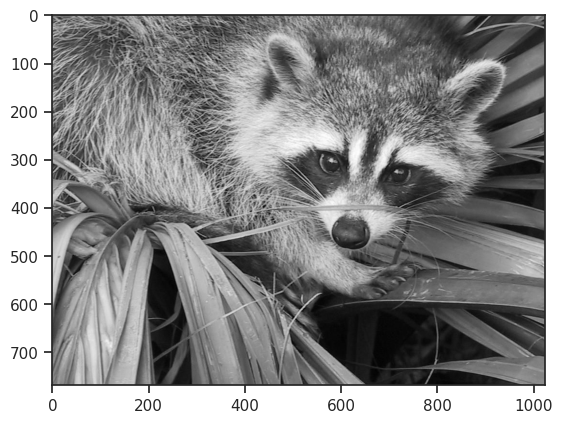

768


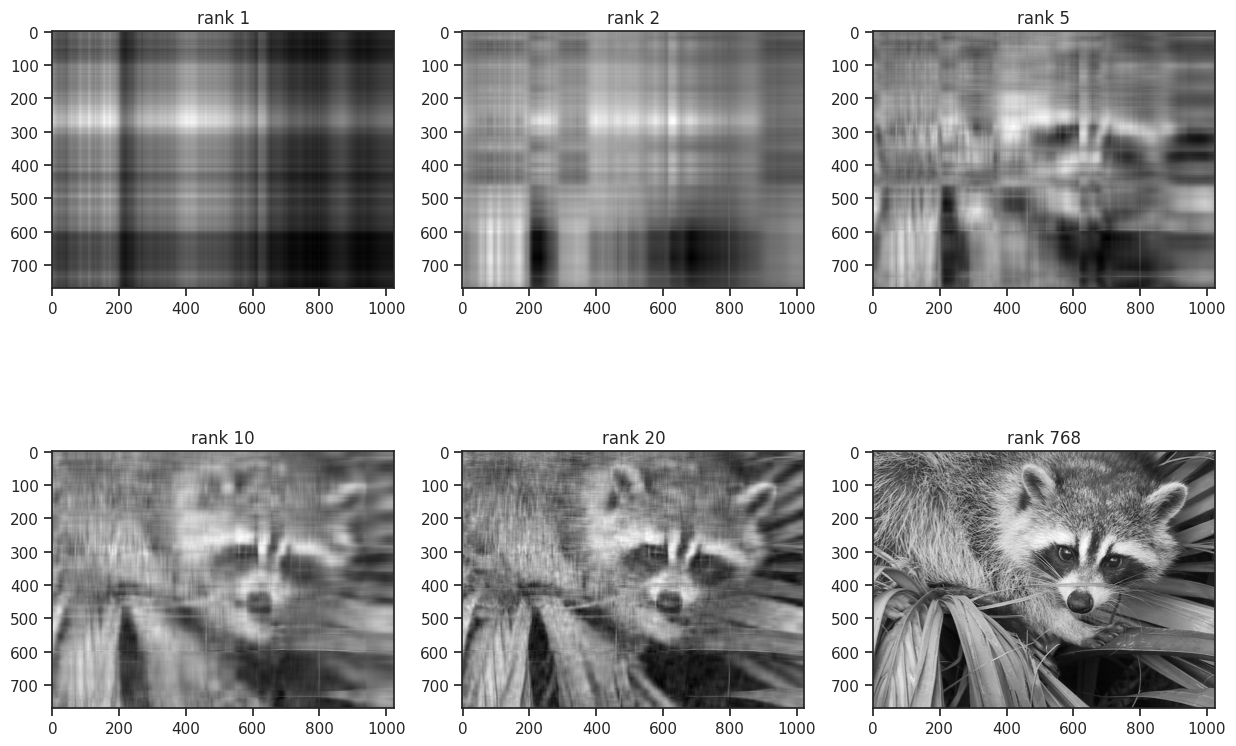

In [46]:
import matplotlib.image


def rgb2gray(rgb):
    # Y' = 0.2989 R + 0.5870 G + 0.1140 B
    return np.dot(rgb[..., :3], [0.2989, 0.5870, 0.1140])


# url = 'https://github.com/probml/pyprobml/blob/master/data/clown.png'
# img = matplotlib.image.imread(url) # invalid png file, apparently...
# X = rgb2gray(img)

import scipy

racoon = scipy.misc.face().astype(np.float32)
X = rgb2gray(racoon)
plt.gray()
plt.imshow(X)
plt.show()

r = np.linalg.matrix_rank(X)
print(r)

U, sigma, V = np.linalg.svd(X, full_matrices=True)
ranks = [1, 2, 5, 10, 20, r]
R = len(ranks)

fig, axes = plt.subplots(2, 3, figsize=[15, 10])
axes = axes.reshape(-1)
for i in range(R):
    k = ranks[i]
    x_hat = np.dot(np.dot(U[:, :k], np.diag(sigma[:k])), V[:k, :])
    ax = axes[i]
    # plt.subplot(2, 3, i+1)
    ax.imshow(x_hat, cmap="gray")
    ax.set_title("rank {}".format(k))
    # save_fig("svdImageDemoClown{}.pdf".format(k))
plt.show()

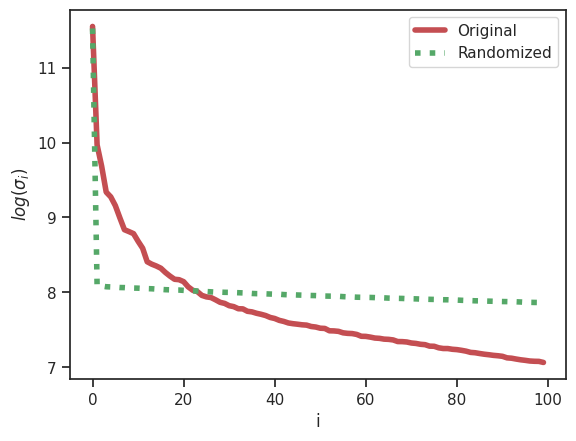

In [47]:
# Plot singular value spectrum
k = 100
plt.figure()
plt.plot(np.log(sigma[:k]), "r-", linewidth=4, label="Original")
plt.ylabel(r"$log(\sigma_i)$")
plt.xlabel("i")


# Compare this to a random shuffled version of the image
x2 = np.random.permutation(X)
# so we convert to a 1d vector, permute, and convert back
x1d = X.ravel()
np.random.shuffle(x1d)  # inplace
x2 = x1d.reshape(X.shape)
U, sigma2, V = np.linalg.svd(x2, full_matrices=False)
plt.plot(np.log(sigma2[:k]), "g:", linewidth=4, label="Randomized")
plt.legend()
# save_fig("svdImageDemoClownSigmaScrambled.pdf")
plt.show()

## Other matrix decompositions <a class="anchor" id="decomp"></a>

In this section, we illustrate a few other matrix decompositions.

### LU decomposition <a class="anchor" id="decomp-LU"></a>

In [48]:
np.random.seed(42)
A = np.random.randn(5, 5)
L, U = scipy.linalg.lu(A, True)
print(L)
print(U)

[[ 0.339 -0.04   0.733  1.     0.   ]
 [-0.16   1.     0.     0.     0.   ]
 [-0.316 -0.348  0.597 -0.423  1.   ]
 [-0.384 -0.712  1.     0.     0.   ]
 [ 1.     0.     0.     0.     0.   ]]
[[ 1.466 -0.226  0.068 -1.425 -0.544]
 [ 0.     1.543  0.778 -0.697  0.456]
 [ 0.     0.     0.895 -1.951 -1.297]
 [ 0.     0.     0.     3.409  0.919]
 [ 0.     0.     0.     0.    -0.576]]


### QR decomposition <a class="anchor" id="decomp-QR"></a>



In [49]:
# Economy vs full mode

np.random.seed(42)
A = np.random.randn(5, 3)
Q, R = scipy.linalg.qr(A, mode="economic")
print("economy: Q shape {}, R shape {}".format(Q.shape, R.shape))
print(Q)
print(R)


Q, R = scipy.linalg.qr(A, mode="full")
print("full: Q shape {}, R shape {}".format(Q.shape, R.shape))
print(Q)
print(R)
assert np.allclose(np.eye(5), np.dot(Q, Q.T), atol=1e-3)

economy: Q shape (5, 3), R shape (3, 3)
[[-0.213 -0.068  0.765]
 [-0.655 -0.119  0.303]
 [-0.679  0.35  -0.49 ]
 [-0.233 -0.221  0.004]
 [-0.104 -0.9   -0.29 ]]
[[-2.327 -0.031  0.622]
 [ 0.     2.13   1.474]
 [ 0.     0.     1.152]]
full: Q shape (5, 5), R shape (5, 3)
[[-0.213 -0.068  0.765 -0.018  0.604]
 [-0.655 -0.119  0.303 -0.248 -0.635]
 [-0.679  0.35  -0.49  -0.046  0.418]
 [-0.233 -0.221  0.004  0.943 -0.085]
 [-0.104 -0.9   -0.29  -0.215  0.222]]
[[-2.327 -0.031  0.622]
 [ 0.     2.13   1.474]
 [ 0.     0.     1.152]
 [ 0.     0.     0.   ]
 [ 0.     0.     0.   ]]


### Cholesky decomposition <a class="anchor" id="decomp-chol"></a>

In [50]:
# Sample from multivariate Gaussian

from scipy.stats import multivariate_normal as mvn


def sample_mvn(mu, Sigma, N):
    L = np.linalg.cholesky(Sigma)
    D = len(mu)
    Z = np.random.randn(N, D)
    X = np.dot(Z, L.T) + np.reshape(mu, (-1, D))
    return X


D = 5
np.random.seed(42)
mu = np.random.randn(D)
A = np.random.randn(D, D)
Sigma = np.dot(A, A.T)
N = 10000
X = sample_mvn(mu, Sigma, N)
mu_hat = np.mean(X)
C = np.cov(X, rowvar=False)
print(C)
print(Sigma)
assert np.allclose(C, Sigma, 1e-0)  # not that close, even after 10k samples...

dist = mvn(mu, Sigma)
X = dist.rvs(size=N)
C = np.cov(X, rowvar=False)
assert np.allclose(C, Sigma, 1e-0)

[[ 3.762 -0.445 -1.572 -0.246 -1.439]
 [-0.445  7.072  4.914  3.109  2.191]
 [-1.572  4.914  4.203  1.467  2.151]
 [-0.246  3.109  1.467  4.522  1.431]
 [-1.439  2.191  2.151  1.431  1.896]]
[[ 3.652 -0.479 -1.567 -0.274 -1.432]
 [-0.479  7.126  4.982  3.107  2.228]
 [-1.567  4.982  4.26   1.488  2.179]
 [-0.274  3.107  1.488  4.53   1.462]
 [-1.432  2.228  2.179  1.462  1.924]]
